### Oscillator

In [30]:
import os
import scipy.io
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation

In [5]:
def exact_solution(d, w0, t):
    '''
    Defines the analytical solution to the under-damped harmonic 
    oscillator problem above.
    '''
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn. Module): 
    '''
    Defines a standard fully-connected network in PyTorch
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn. Sequential(*[ nn. Sequential(*[ nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [6]:
torch.manual_seed(123)

# Define the output folder for the images
output_folder = os.path.join(os.getcwd(), "images")
os.makedirs(output_folder, exist_ok=True)

# Define list for loss values to be plotted
losses = []

# Define the PINN model
pinn = FCN(1, 1, 32, 3)

# Define boundary points for the boundary loss
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

# Define training points over the entire domain for the physics loss
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# Define the parameters in the PDE
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Arrays for validating
t_test = torch.linspace(0, 1, 100).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Define the number of epochs
num_epochs = 15000

# Train the PINN
for i in range(num_epochs):
    optimizer.zero_grad()

    # Loss coefficients
    lambda1, lambda2 = 1e-1, 1e-4

    # Compute the boundary loss
    u_pred = pinn(t_boundary)
    loss1 = (torch.squeeze(u_pred) - 1)**2
    # boundary_loss = torch.mean((u_pred - 0)**2)

    dudt = torch.autograd.grad(u_pred, t_boundary, torch.ones_like(u_pred), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Compute the physics loss
    u_pred = pinn(t_physics)

    dudt = torch.autograd.grad(u_pred, t_physics, torch.ones_like(u_pred), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u_pred)**2)

    # Compute the total loss
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        losses.append(loss.item())
        print(f"Epoch {i}: Loss {loss}")
        u = pinn(t_test).detach()
        plt.figure(figsize=(4, 4))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, c='g', alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, c='r', alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact Solution", c='pink')
        plt.plot(t_test[:,0], u[:,0], label="PINN Solution", c='b')
        plt.title(f"Training Step {i}")
        plt.legend()
        
        image_path = os.path.join(output_folder, 
                                  "epoch_{:0{width}d}.png".format(i, width=len(str(num_epochs))))
        plt.savefig(image_path)
        plt.close()

Epoch 0: Loss 1.0218925476074219
Epoch 100: Loss 0.7661262154579163
Epoch 200: Loss 0.7359812259674072
Epoch 300: Loss 0.7013713121414185
Epoch 400: Loss 0.44512879848480225
Epoch 500: Loss 0.18587861955165863
Epoch 600: Loss 0.1528879553079605
Epoch 700: Loss 0.11743609607219696
Epoch 800: Loss 0.08066191524267197
Epoch 900: Loss 0.06065107882022858
Epoch 1000: Loss 0.049521755427122116
Epoch 1100: Loss 0.040381625294685364
Epoch 1200: Loss 0.035431139171123505
Epoch 1300: Loss 0.033625390380620956
Epoch 1400: Loss 0.032558511942625046
Epoch 1500: Loss 0.03179442882537842
Epoch 1600: Loss 0.03069552592933178
Epoch 1700: Loss 0.030698055401444435
Epoch 1800: Loss 0.02836444601416588
Epoch 1900: Loss 0.02977040782570839
Epoch 2000: Loss 0.024662094190716743
Epoch 2100: Loss 0.02371646836400032
Epoch 2200: Loss 0.019304020330309868
Epoch 2300: Loss 0.016757575795054436
Epoch 2400: Loss 0.014690087176859379
Epoch 2500: Loss 0.013762373477220535
Epoch 2600: Loss 0.011877194978296757
Epoch 

In [19]:
import imageio

os.listdir(output_folder)
images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]
imageio.mimsave(os.path.join(os.getcwd(), 'animation.gif'), images, fps=30, duration=0.1, loop=0)

C:\Users\dsash\AppData\Local\Temp\ipykernel_16816\2480283814.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]


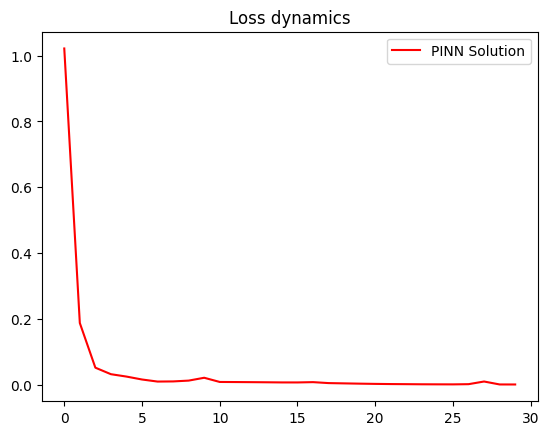

In [20]:
plt.plot(list(range(len(losses))), losses, label="PINN Solution", c='r')
plt.title(f"Loss dynamics")
plt.legend()

### Heat

In [22]:
def heat_equation_2d(x):
    # x - это тензор, содержащий пространственные и временные координаты (x, y, t)
    u = x[:, 0] # Предположим, что u - это температура
    t = x[:, 1] # t - время
    # Уравнение теплопроводности в 2D
    # d(u)/dt = alpha * (d^2(u)/dx^2 + d^2(u)/dy^2)
    alpha = 0.01 # Коэффициент теплопроводности
    du_dt = torch.autograd.grad(u, t, create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dt, x[:, 0], create_graph=True)[0]
    d2u_dy2 = torch.autograd.grad(du_dt, x[:, 1], create_graph=True)[0]
    heat_eq = du_dt - alpha * (d2u_dx2 + d2u_dy2)
    return heat_eq

In [26]:
def visualize_points(x_test, y_test, u_test, norm):
    plt.scatter(x_test, y_test, c=u_test, marker='o', cmap='viridis', norm=norm)
    plt.title('Scatter Plot of Points')
    plt.colorbar(label='Velocity')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')
    plt.show()

In [31]:
def set_boundary_conditions(edge_temps, square_size, num_points_per_edge):
    x_boundary_top = np.linspace(0, square_size, num_points_per_edge)
    y_boundary_top = np.ones_like(x_boundary_top) * square_size

    x_boundary_right = np.ones(num_points_per_edge) * square_size
    y_internal_right = np.linspace(0, square_size, num_points_per_edge)

    x_boundary_bottom = np.linspace(square_size, 0, num_points_per_edge)
    y_boundary_bottom = np.zeros_like(x_boundary_bottom)

    x_boundary_left = np.zeros(num_points_per_edge)
    y_boundary_left = np.linspace(square_size, 0, num_points_per_edge)

    x_boundary = np.concatenate([x_boundary_top, x_boundary_right, x_boundary_bottom, x_boundary_left])
    y_boundary = np.concatenate([y_boundary_top, y_internal_right, y_boundary_bottom, y_boundary_left])

    u_boundary = np.zeros_like(x_boundary)

    u_boundary[:num_points_per_edge] = edge_temps[0]  # Top edge
    u_boundary[num_points_per_edge:2*num_points_per_edge] = edge_temps[1]  # Right edge
    u_boundary[2*num_points_per_edge:3*num_points_per_edge] = edge_temps[2]  # Bottom edge
    u_boundary[3*num_points_per_edge:] = edge_temps[3]  # Left edge
    
    t_boundary = np.linspace(0, 1, len(x_boundary))

    return x_boundary, y_boundary, t_boundary, u_boundary

In [33]:
def set_initial_conditions(initial_distribution_func, square_size, num_points):
    x_initial = np.random.uniform(0, square_size, num_points)
    y_initial = np.random.uniform(0, square_size, num_points)
    
    t_initial = np.zeros_like(x_initial)
    
    u_initial = initial_distribution_func(x_initial, y_initial)
    
    return x_initial, y_initial, t_initial, u_initial

def constant_initial_distribution(x, y):
    return np.ones_like(x) * 2

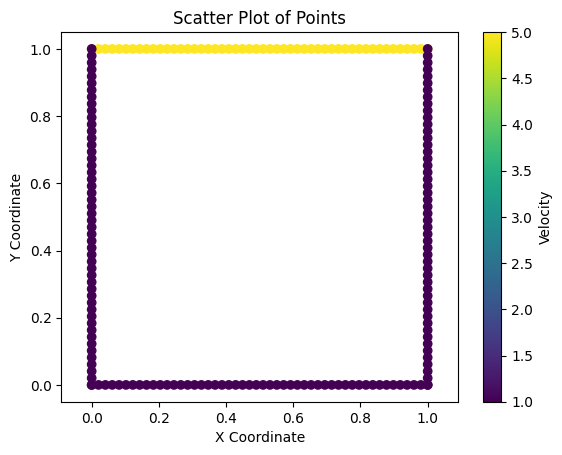

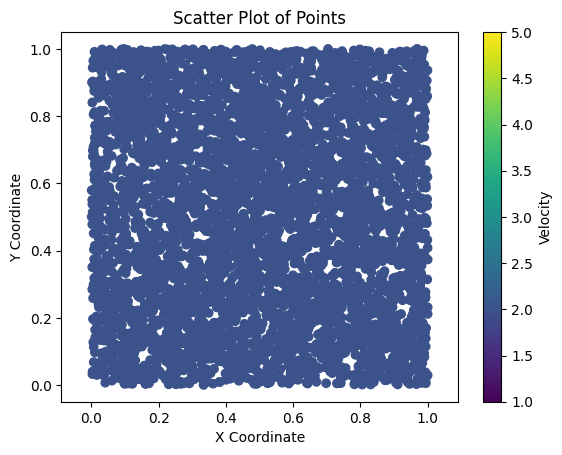

In [34]:
# Set temperatures at the edges [top, right, bottom, left]
edge_temperatures = [5, 1, 1, 1]

# Size of calculation area
square_size = 1.0

# Number of points per edge
num_points_per_edge = 50

# Generate boundary conditions
x_boundary, y_boundary, t_boundary, u_boundary = set_boundary_conditions(edge_temperatures, square_size, num_points_per_edge)

# Number of points in calculation area
num_points_initial = 5000

# Generate initial conditions
x_initial, y_initial, t_initial, u_initial = set_initial_conditions(constant_initial_distribution, square_size, num_points_initial)

temperature_min = min(np.min(u_boundary), np.min(u_initial))
temperature_max = max(np.max(u_boundary), np.max(u_initial))
norm = Normalize(vmin=temperature_min, vmax=temperature_max)

visualize_points(x_boundary, y_boundary, u_boundary, norm)
visualize_points(x_initial, y_initial, u_initial, norm)

In [53]:
# Apply boundary conditionals
def apply_boundary_conditions(input_tensor, initial_temperature, low_boundary_temperature, high_boundary_temperature):
    result_tensor = input_tensor.clone()

    result_tensor[:, :, 0] = initial_temperature
    result_tensor[:, 0, :] = low_boundary_temperature # Left boundary 
    result_tensor[:, -1, :] = low_boundary_temperature # Right boundary 
    result_tensor[0, :, :] = high_boundary_temperature # Upper boundary
    result_tensor[-1, :, :] = low_boundary_temperature # Bottom boundary

    return result_tensor

N = 100
T = 50
temp_data_shape = (N, T)
temp_data = torch.zeros(temp_data_shape, requires_grad=True)

initial_temperature = 1.0
low_boundary_temperature = 2.0
high_boundary_temperature = 5.0

# temp_star = apply_boundary_conditions(temp_data, 
#                                     initial_temperature, 
#                                     low_boundary_temperature, 
#                                     high_boundary_temperature)

# P_star = data['p_star']  # N x T

# t_star = data['t']  # T x 1
t_star = np.linspace(0, 1, T)
print("t_star", t_star.shape)

# X_star = data['X_star']  # N x 2

# x_test = X_star[:, 0:1]
x_test = np.random.rand(N, 1)

print("x", x_test.shape)

# y_test = X_star[:, 1:2]
y_test = np.random.rand(N, 1)
print("y", y_test.shape)

# p_test = P_star[:, 0:1]
temp_init_test = np.ones_like(x_test, initial_temperature)
print("Init temp", temp_init_test.shape)

# print(result_tensor)

t_star (50,)
x (100, 1)
y (100, 1)


TypeError: Cannot interpret '1.0' as a data type

In [51]:
# Функция для уравнения теплопроводности в 2D
def heat_equation_2d(x):
    # x - это тензор, содержащий пространственные и временные координаты (x, y, t)
    u = x[:, 0]  # Предположим, что u - это температура
    t = x[:, 1]  # t - время
    # Уравнение теплопроводности в 2D
    # d(u)/dt = alpha * (d^2(u)/dx^2 + d^2(u)/dy^2)
    alpha = 0.01  # Коэффициент теплопроводности
    du_dt = torch.autograd.grad(u, t, create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dt, x[:, 0], create_graph=True)[0]
    d2u_dy2 = torch.autograd.grad(du_dt, x[:, 1], create_graph=True)[0]
    heat_eq = du_dt - alpha * (d2u_dx2 + d2u_dy2)
    return heat_eq

In [ ]:
class PINN():
    def __init__(self, X, Y, T):
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True)

        # Null vector to test loss
        self.null = torch.zeros((self.x.shape[0], 1))

        # Initialize network:
        self.network()

        # Optimizer
        self.optimizer = torch.optim.LBFGS(self.net.parameters(), 
                                           lr=1, 
                                           max_iter=200000, 
                                           max_eval=50000,
                                           history_size=50, 
                                           tolerance_grad=1e-05, 
                                           tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        # Loss function
        self.mse = nn.MSELoss()

        # Loss
        self.ls = 0

        # Iteration number
        self.iter = 0

    def network(self):
        self.net = nn.Sequential(
            nn.Linear(3, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 2))

    def function(self, x, y, t):
        u_pred = self.net(torch.hstack((x, y, t)))

        dudx = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
        d2udx2 = torch.autograd.grad(dudx, x, grad_outputs=torch.ones_like(dudx), create_graph=True)[0]
        dudy = torch.autograd.grad(u_pred, y, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
        d2udy2 = torch.autograd.grad(dudy, y, grad_outputs=torch.ones_like(dudy), create_graph=True)[0]
        dudt = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

        return u_pred, dudt, d2udx2, d2udy2

    def closure(self):
        # Reset gradients
        self.optimizer.zero_grad()

        # u, v, p, g and f predictions:
        u_prediction, dudt, d2udx2, d2udy2 = self.function(self.x, self.y, self.t)

        # Calculate losses

        # TODO: write the loss function for boundary conditions, initial conditions and the heat equation
        # u_loss = self.mse(u_prediction, self.u)
        # f_loss = self.mse(f_prediction, self.null)
        # self.ls = u_loss + v_loss + f_loss

        # Derivative with respect to weights
        self.ls.backward()

        self.iter += 1
        if not self.iter % 1:
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls))

        return self.ls

    def train(self):
        # Training loop
        self.net.train()
        self.optimizer.step(self.closure)

In [44]:
# Rearrange Data
XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
print("XX", XX.shape)
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
print("YY", YY.shape)
TT = np.tile(t_star, (1, N)).T  # N x T
print("TT", TT.shape, "\n")

print("U_star", U_star.shape) # Velocity value on x and y

UU = U_star[:, 0, :]  # N x T, only x velocity
print("UU", UU.shape)
VV = U_star[:, 1, :]  # N x T, only y velocity
print("VV", VV.shape)
PP = P_star  # N x T
print("PP", PP.shape)

XX (5000, 200)
YY (5000, 200)
TT (5000, 200) 

U_star (5000, 2, 200)
UU (5000, 200)
VV (5000, 200)
PP (5000, 200)


In [40]:
x = XX.flatten()[:, None]  # NT x 1
print("x", x.shape)
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

x (1000000, 1)


In [43]:
N_train = 10 # Amount of training data

idx = np.random.choice(N * T, N_train, replace=False), # N_train x 1, params is (max_value, amount, without replacement)



x_train = x[idx, :] # Here is wired slice
# x_train = x[idx] # I think it is better
print("x_train", x_train.shape)

y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

x_train (1, 10, 1)


In [ ]:
pinn = PINN(x_train, y_train, t_train, u_train, v_train)

pinn.train()

torch.save(pinn.net.state_dict(), 'model.pt')

In [ ]:
# N_train = 5000

# data = scipy.io.loadmat('cylinder_wake.mat')

# U_star = data['U_star']  # N x 2 x T
# P_star = data['p_star']  # N x T
# t_star = data['t']  # T x 1
# X_star = data['X_star']  # N x 2

# N = X_star.shape[0]
# T = t_star.shape[0]

# x_test = X_star[:, 0:1] # only x coordinate
# y_test = X_star[:, 1:2] # only y coordinate
# p_test = P_star[:, 0:1] # only initial pressure, for first time step
# u_test = U_star[:, 0:1, 0] # only initial speed, for first time step
# t_test = np.ones((x_test.shape[0], x_test.shape[1]))

# # Rearrange Data
# XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
# YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
# TT = np.tile(t_star, (1, N)).T  # N x T

# UU = U_star[:, 0, :]  # N x T
# VV = U_star[:, 1, :]  # N x T
# PP = P_star  # N x T

# x = XX.flatten()[:, None]  # NT x 1
# y = YY.flatten()[:, None]  # NT x 1
# t = TT.flatten()[:, None]  # NT x 1

# u = UU.flatten()[:, None]  # NT x 1
# v = VV.flatten()[:, None]  # NT x 1
# p = PP.flatten()[:, None]  # NT x 1

# Training Data
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

'''
pinn = PINN(x_train, y_train, t_train, u_train, v_train)

pinn.train()

torch.save(pinn.net.state_dict(), 'model.pt')
'''

pinn = PINN(x_train, y_train, t_train, u_train, v_train)
pinn.net.load_state_dict(torch.load('model.pt'))
pinn.net.eval()

x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)

u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, t_test)

u_plot = p_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (50, 100))

fig, ax = plt.subplots()

plt.contourf(u_plot, levels=30, cmap='jet')
plt.colorbar()
#plt.show()

def animate(i):
    ax.clear()
    u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, i*t_test)
    u_plot = p_out.data.cpu().numpy()
    u_plot = np.reshape(u_plot, (50, 100))
    cax = ax.contourf(u_plot, levels=20, cmap='jet')
    plt.xlabel(r'$x$')
    plt.xlabel(r'$y$')
    plt.title(r'$p(x,\; y, \; t)$')

# Call animate method
ani = animation.FuncAnimation(fig, animate, 20, interval=1, blit=False)
#ani.save('p_field_lbfgs.gif')
#plt.close()
# Display the plot
plt.show()